# Experiments with the LIME interpretation model

In this blog post I will share some experiments on the LIME interpretation model. LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938). Its purpose is to explain a model prediction for a specific sample in a human-interpretable way. It provides a way to investigate a model predictions beyond the sole classification or regression standard metrics. 

In order to set the playground I first build a quick model on the [IMDB](www.imdb.com) sentiment analysis dataset, which contains movie reviews with an associated sentiment (0 for negative, 1 for positive). Data was downloaded [on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/download/labeledTrainData.tsv.zip). 


In [1]:
import pandas as pd
df = pd.read_csv('./labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


## Text preprocessing

Here I simply **replace rare words with an "oov" (out-of-vocabulary) tag**. This step is crucial as rare words (tipically less than 10 occurences) do not appear often enough for the model to learn pattern with it, and they increase the vector space representation dimension dramatically with most text vectorization method (such as bag-of-words or TF-IDF).

In [91]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

texts = [t.lower() for t in df['review'].values]
y = df['sentiment'].values

# 1) Compute word frequencies
all_tokens = [token for t in texts for token in t.split()] 
frequencies = defaultdict(int)
for w in all_tokens:
    frequencies[w] += 1
print('Vocabulary size before rare words tagging:', len(set(all_tokens)))

# 2) Replace words occuring less than 10 times in the corpus with an 
# out-of-vocabulary tag 
texts = [' '.join([w if frequencies[w] > 10 else '<oov>' 
                   for w in t.split()])
         for t in texts]
print('Vocabulary size after rare words tagging:', 
      len(set([token for t in texts for token in t.split()])))

# 3) Split train and test sets (should be done before rare words 
# tagging in real world applications)
texts_train, texts_test, y_train, y_test = \
    train_test_split(texts, y, random_state=42)

Vocabulary size before rare words tagging: 257663
Vocabulary size after rare words tagging: 25341


## Building a simple sentiment prediction pipeline
Here I build a simple data transformation pipeline for text classification: a [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) vectorizer followed by a random forest classifier. 

This classification pipeline is prettty standard but it is already hard to interpret.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

vectorizer = TfidfVectorizer()
classifier = RandomForestClassifier(n_estimators=100, max_depth=10)

pipeline = make_pipeline(vectorizer, classifier)

pipeline.fit(texts_train, y_train)
y_preds = pipeline.predict(texts_test)

print('Accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))
print('F1-score: {:.2f} %'.format(100*metrics.f1_score(y_preds, y_test)))

Accuracy: 82.32 %
F1-score: 83.14 %


## Analysis: what has the model learnt?
A F1-score of 80% is already enjoyable for some classification tasks, but **we have no idea if the classifier has learnt useful features yet**. For instance an additional HTML tag may have been added to the positive examples for obscure reasons, in which case our classifier would have a nice score but would have mostly learnt to recognize this artificial tag presence. This situation happens quite often in data science as some variable "from the future" sometimes leak in your dataset. 

To avoid such ungeneralizable model training, one has to investigate the model prediction in addition to the computation of the score on a test set.

### Feature importance

A standard way to understand the predictions of a trained random forest classifier is to compute feature (Gini) importance. Feature importance in trees is computed as the (normalized) mean Gini impurity reduction brought by the features. In a word it describes how well the feature splits classes in your trees. 

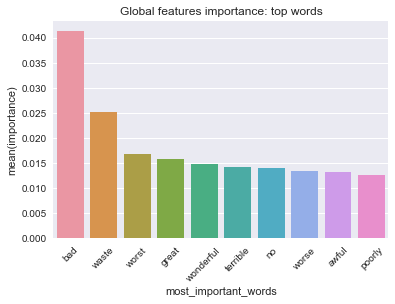

In [93]:
import seaborn as sns
%matplotlib inline

# Create a dictionary with most important features
importances = pipeline.named_steps['randomforestclassifier'].feature_importances_
top_indices = np.argsort(importances)[::-1][:10]
features_names = np.array(vectorizer.get_feature_names())
words_importance = pd.DataFrame({'most_important_words': features_names[top_indices],
                                 'importance': importances[top_indices]})

sns.barplot(x="most_important_words", y="importance", data=words_importance)
plt.xticks(rotation=45)
plt.title('Global features importance: top words');

So now we have the most important words on average on the training set. The most important words make sense, but
* We **don't know if a word contributes positively or negatively**
* The feature importance attribute is **specific to tree-based models**
* If we **don't undestand specific predictions**, we cannot investigate the model if we doubt a given prediction

For the last point there is a work-around: we can compute the model importance of the words that are present in a specific text. 

Here is an example:

In [139]:
# We choose a sample from test set
idx = 1
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print(text_sample)
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

this film pulls you in from the <oov> because it grabs our attention by <oov> yeah, that this story is opening with a cliché  a <oov> /><br />in hands other than <oov> i wouldn't have given it an 8 as this material has been done over and over again: the great reunion of a once famous, pick one please, team, army <oov> theatre group, singers, <oov> /><br />but this movie never <oov> to cheap <oov> and when you think it is going to it <oov> off in another direction. a case in point is the flowers that are sent by an admirer to <oov> /><br />the band members are an interesting group and ride above the clichés too. one is in jail, one has found religion, one is an <oov> and one has sunk into <oov> but the <oov> de <oov> rediscovered by <oov> <oov> by her <oov> interest, carries us along and makes us overlook the sometimes simplistic nature of the plot.<br /><br />the cast are a who's who of talent, leslie caron, the incomparable <oov> cleo <oov> with her amazing high notes, a last perform

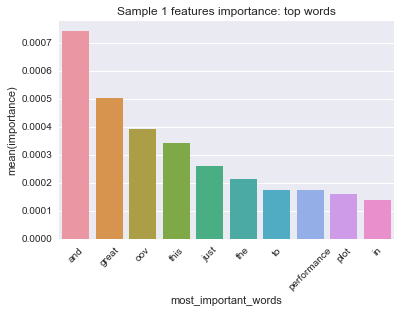

In [140]:
sample_importances = (vectorizer.transform([text_sample]).toarray()*importances).flatten()
sample_top_indices = np.argsort(sample_importances)[::-1][:10]
sample_words_importance = pd.DataFrame(
    {'most_important_words': np.array(vectorizer.get_feature_names())[sample_top_indices],
    'importance': sample_importances[sample_top_indices]})

sns.barplot(x="most_important_words", y="importance", data=sample_words_importance)
plt.xticks(rotation=45)
plt.title('Sample {} features importance: top words'.format(idx));

### Example specific analysis with LIME
In their article [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938), Marco Ribeiro and his collaborators introduce a new framework for machine learning models interpretation called LIME (Local Interpretable Model-agnostic Explanations). 

The purpose of LIME is to give an **interpretable explanation for a given input sample prediction**, by locally approximating the model to be explained $f$ by an "explanation model" $g$ that is linear and has an interpretable domain. While your original model may operate on a complex vector space such as the TF-IDF representation of a text, or the HOG features of a picture, the explanation model's domain is a human interpretable one, such as a vector indicating the presence or absence of a few critical words in a text.

LIME requires:
* a mapping $x\rightarrow x'$ of the model input vector to an interpretable representation $\{0,1\}^{d'}$. Here, while the original $x$ may be a complex vector in $\mathbb{R}^n$, the vector $x'$ just indicates the absence/ presence of basic features (words for text, pixels for pictures).
* A proximity measure function $\Pi_{x}$ measuring closeness to the sample $x$ under scrutiny. Usually a normal distribution over the distance (cosine distance for texts, L2-norm for pictures). 
* A choice for the interpetable model $g$. The first choice is a linear model (i.e. a linear regression for regression and a logistic regression for classification).


Technically, for a given sample $x\in\mathbb{R}^d$ to be explained we determine the corresponding vector $x'\in\{0,1\}^{d'}$ in the explanable feature space. We generate a set of $N$ artificial points $z_i'$, by randomly cancelling coordinates or $x'$(uniform distribution). Then we fit a simple model $g$ (K-LASSO, i.e. a logistic regression with at most $K$ non-zero weights) that must reproduce the predictions of $f$ at best by minimizing the dissimilarity function 

$$\mathcal{L}(f, g, \Pi_x)= \sum_{z, z'} \Pi_x(z) \left[f(z) - g(z') \right]^2.$$ Note that the dissimilarity is 0 when $f$ and $g$ give the exact same predictions (which is why $\mathcal{L}$ minimization is also called "local fidelity maximization"). Also, dissimilarities are weighted by the $\Pi_x$ proximity between random samples $z$ and the original sample $x$ under investigation, such that predictions discrepancies far away from $x$ are less penalized.

Let's take an example:
* Suppose we investigate the prediction of a a sentiment classification model $f$ for the sentence "am quite happy", that is scored $0.7$ by $f$.
* Assume that due to our corpus the TF-IDF representation of the sentence "am quite happy" is $x=(0.2, 0.3, 0.1, 0, \dots)$, i.e. the first 3 coordinates correspond to the words "am", "quite" and "happy" in our corpus.
* The interpretable vector corresponding to $x$ is $x'=(1, 1, 1, 0, \dots)$. 
* In order to define a neighborhood of $x'$ we generate some sparser samples $z_1'=(1, 0, 1, 0, \dots)$ and $z_2'=(1, 0, 0, 0, \dots)$ in the vicinity of $x'$.
* We compute the corresponding vectors in the original space: $z_1=(0.2, 0, 0.1, 0, \dots)$ and $z_2=(0.2, 0, 0, 0, \dots)$
* We compute the $d'$ weights of the explanation model $g$ by minimization of dissimilarity $\mathcal{L}$  with $f$ predictions (only $K$ of the $g$ function weights will be non-zero, were $K$ is an hyperparameter of LIME). For example if we obtain the following weights $(0, -0.5, 1.2, \dots)$, that means the presence of the word "quite" contributs negatively to the prediction, with weight $-0.5$, while the word "happy" contributes positively, with weight $1.2$.


Simple examples can be found on the [Github repository of the project](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html).


/Users/nthiebaut/anaconda/envs/nlp/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


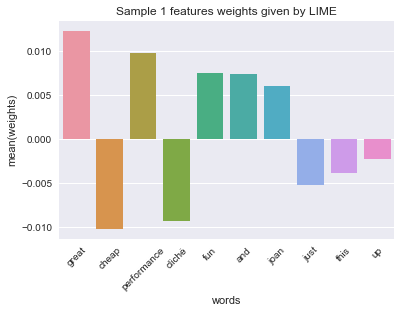

In [141]:
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

LIME managed to extract mostly the same important words as the model itself, without knowing anything about it! We now have rational numbers, allowing the human interpreter to understand what words were the most important. Also, this technique can be replicated instantly for any model, so let's try with a neural network! (next blog post :)